## Vehicle Detection

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
3. Run a pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.




## Libraries

In [1]:
import cv2
import pickle
import glob
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg

/Users/212361198/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Helper functions

In [17]:
def draw_labeled_box(img, labels):
    """
    Iterate throufh all detected vehicles and then draw the box on the image
    :param img: 
    :param labels: 
    :return: 
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (191, 0, 255), 6)
    # Return the image
    return img

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    """
    Return HOG features and visualization
    :param img:
    :param orient:
    :param pix_per_cell:
    :param cell_per_block:
    :param vis:
    :param feature_vec:
    :return:
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
     Compute color histogram features
    :param img:
    :param nbins:
    :param bins_range:
    :return:
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def bin_spatial(img, size=(32, 32)):
    """
    Compute binned color features
    :param img:
    :param size:
    :return:
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract features from a list of images
    :param imgs:
    :param color_space:
    :param spatial_size:
    :param hist_bins:
    :param orient:
    :param pix_per_cell:
    :param cell_per_block:
    :param hog_channel:
    :param spatial_feat:
    :param hist_feat:
    :param hog_feat:
    :return:
    """

    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat:

            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features

def split_data(vehicle_features,non_vehicle_features):
    """
    Split the data into randomized training and test sets
    :param vehicle_features:
    :param non_vehicle_features:
    :return:
    """
    x = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
    # Fit a per-column scaler
    x_scaler = StandardScaler().fit(x)
    # Apply the scaler to X
    scaled_X = x_scaler.transform(x)

    # Define the labels vector
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test,x_scaler

def train_with_svc(X_train,y_train):
    """
    Train with Support Vector Classification
    :param X_train:
    :param y_train:
    :return:
    """
    svc = SVC(kernel='rbf')
    svc.fit(X_train, y_train)
    return svc

def convert_color(img, conv='RGB2YCrCb'):
    """
    Convert color image
    :param img:
    :param conv:
    :return:
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def plot(img1, img2, img1_title, img2_title):
    """
    Plot image 1 and image 2
    :param img1:
    :param img2:
    :param img1_title:
    :param img2_title:
    :return:
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(img1_title, fontsize=10)
    ax2.imshow(img2)
    ax2.set_title(img2_title, fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def save_classifier(svc, x_scaler, pickle_file_path):
    """
    Save the classifier on disk as a pickle file
    :param svc:
    :param x_scaler:
    :param pickle_file_path:
    """
    file = open(pickle_file_path, "wb")
    pickle.dump(svc, file)
    pickle.dump(x_scaler, file)
    file.close()

def load_classifier(pickle_file_path):
    """

    :param pickle_file_path:
    :return:
    """
    f = open(pickle_file, "rb")
    svc = pickle.load(f)
    x_scaler = pickle.load(f)
    f.close()
    return svc,x_scaler


def extract_vehicle_features(img, svc, x_scaler):
    """
    Extract features using hog sub-sampling and make predictions
    :param img: 
    :param svc: 
    :param x_scaler: 
    :return: 
    """
    ystart = 400
    ystop = 656
    scale = 1.5

    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    heatmap = np.zeros_like(img[:, :, 0])

    img_to_search = img[ystart:ystop, :, :]
    ctrans_to_search = img_to_search
    if scale != 1:
        imshape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_to_search[:, :, 0]
    ch2 = ctrans_to_search[:, :, 1]
    ch3 = ctrans_to_search[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog_file = "svc-model-2.pickle"
    if Path(hog_file).is_file():
        f = open(hog_file, "rb")
        hog1 = pickle.load(f)
        hog2 = pickle.load(f)
        hog3 = pickle.load(f)
        f.close()
    else:
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        f = open(hog_file, "wb")
        pickle.dump(hog1, f)
        pickle.dump(hog2, f)
        pickle.dump(hog3, f)
        f.close()

    for xb in range(nxsteps):
        if (xb * cells_per_step * pix_per_cell * scale) > 700:
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_to_search[ytop:ytop + window, xleft:xleft + window], (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = x_scaler.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    if xbox_left > 700:
                        heatmap[ytop_draw + ystart:ytop_draw + ystart + win_draw, xbox_left:xbox_left + win_draw] += 1

    return heatmap

# 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

## Get a list of Vehicles and Non-Vehicles images

In [16]:
vehicles = []
non_vehicles = []
vehicles_images = glob.glob('../vehicles/**/*.png',recursive=True)
for image in vehicles_images:
    vehicles.append(image)
    
no_vehicles_images = glob.glob('../non-vehicles/**/*.png',recursive=True)
for image in no_vehicles_images:
    non_vehicles.append(image)
    
print("Vehicles Images size: {}".format(len(vehicles)))
print("No Vehicles Images size: {}".format(len(non_vehicles)))


Vehicles Images size: 8792
No Vehicles Images size: 8968


## Plot a Vehicle and Non-Vehicle image

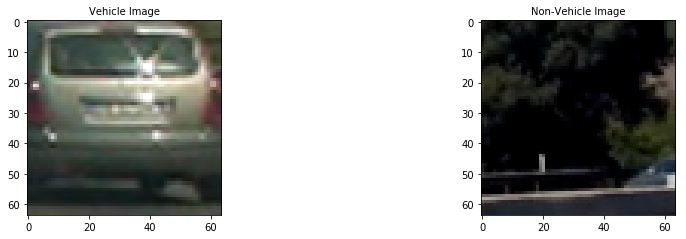

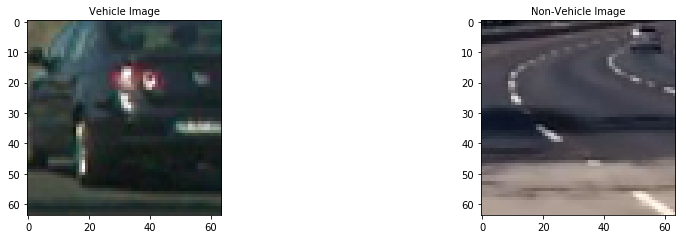

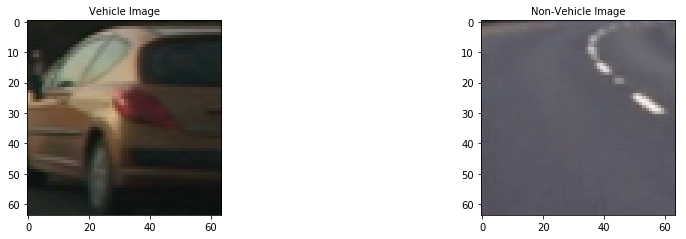

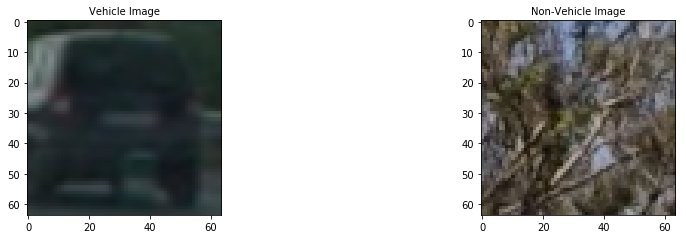

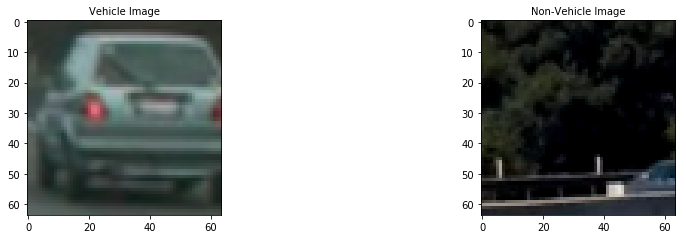

In [18]:
for i in range(5):
    vehicle_img = mpimg.imread(vehicles[i])
    non_vehicle_img = mpimg.imread(non_vehicles[i])
    plot(vehicle_img,non_vehicle_img,'Vehicle Image','Non-Vehicle Image')

## Generate Support Vector Classification

## Extract Features 

In [22]:
vehicle_features = extract_features(vehicles)
non_vehicle_features = extract_features(non_vehicles)

## Split Data into randomized training and test sets

In [35]:
print("Please wait...")
X_train, X_test, y_train, y_test,x_scaler = split_data(vehicle_features,non_vehicle_features)
print("Done splitting the data into randomized training and test sets.") 

Please wait...
Done splitting the data into randomized training and test sets.


## Train with the Support Vector Classification

In [27]:
print("Please wait...")
svc= train_with_svc(X_train,y_train)
print('Test Accuracy of SVC:', round(svc.score(X_test, y_test), 4))
print("Done with Training")


Please wait...
Test Accuracy of SVC: 0.9961
Done with Training


## Save Classifier On Disk

In [36]:
pickle_file = "VehicleDetectionModel.pickle"
save_classifier(svc,x_scaler,pickle_file)

## Load Classifer from Disk

In [3]:
pickle_file = "VehicleDetectionModel.pickle"
svc,x_scaler=load_classifier(pickle_file)

In [4]:
print("SVC Information: {}".format(svc))

SVC Information: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [5]:
print("X Scaler Information: {}".format(x_scaler))

X Scaler Information: StandardScaler(copy=True, with_mean=True, with_std=True)


# 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

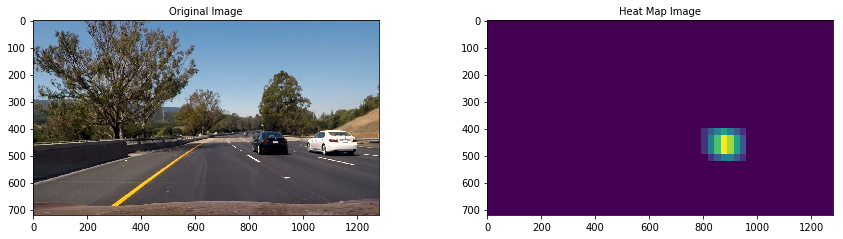

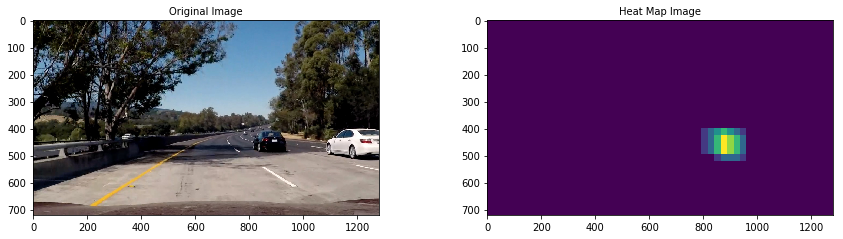

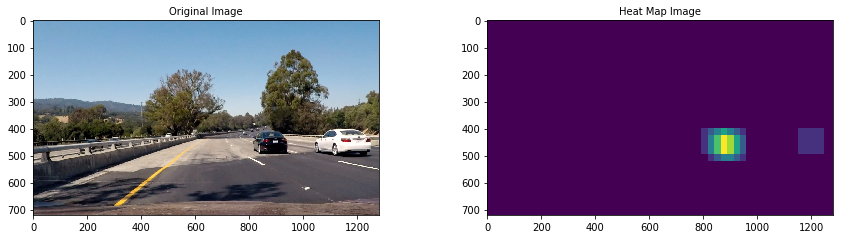

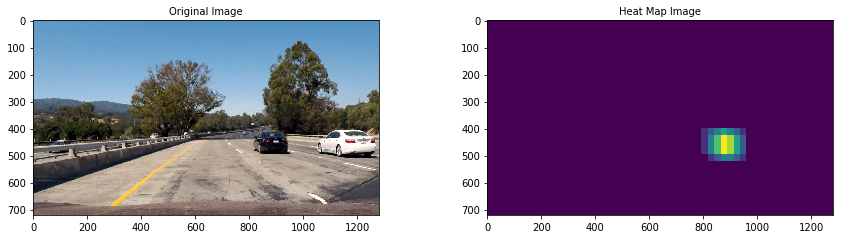

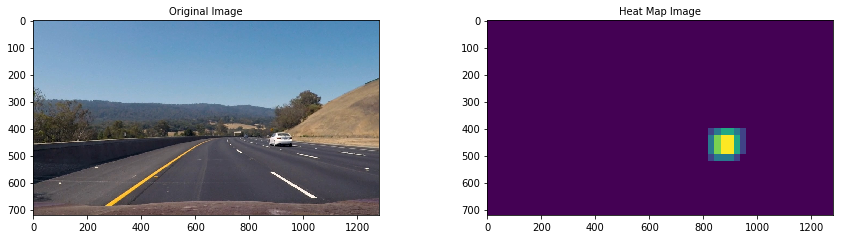

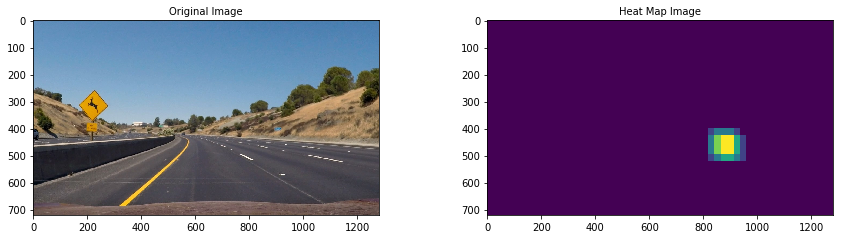

In [14]:
test_images = glob.glob('../test_images/*.jpg')
for image_path in test_images:
    img = mpimg.imread(image_path)
    img = img.astype(np.float32)/255
    out_img = extract_vehicle_features(img,svc,x_scaler)
    plot(img,out_img,'Original Image','Heat Map Image')

## 3. Run a pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [20]:
heatmap = np.zeros_like(img[:, :, 0])

heatmaps = []
for i in range(10):
    heatmaps.append(heatmap)

frame_number = 0
threshold_detection = 15


def detect_vehicles(img):
    global x_scaler
    global frame_number
    global threshold_detection

    draw_img = np.copy(img)

    img = img.astype(np.float32) / 255
    thisheatmap = extract_vehicle_features(img, svc, x_scaler)

    heatmaps[frame_number % 10] = thisheatmap
    frame_number += 1

    addheatmap = np.zeros_like(img[:, :, 0])
    for h in heatmaps:
        addheatmap = cv2.add(addheatmap, h)
        
    addheatmap[addheatmap <= threshold_detection] = 0

    labels = label(addheatmap)
    draw_img = draw_labeled_box(draw_img, labels)
    return draw_img

In [21]:
clip1 = VideoFileClip("../project_video.mp4")
video_output = 'project_video_out.mp4'
out_clip = clip1.fl_image(detect_vehicles).subclip(30,32)
#out_clip = clip1.fl_image(detect_vehicles)
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


 98%|█████████▊| 50/51 [02:10<00:02,  2.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 9s, sys: 807 ms, total: 2min 10s
Wall time: 2min 11s
